# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

Answer <br> ***The data is collected from Portuguese bank 17 direct marketing campaings which occurred between May 2008 and November 2010. The data attributes obtained from the campaign related to contact information, and therefore were augmented with internal bank data (for client's characteristics)***

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
data = df.copy()

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
data.shape

(41188, 21)

In [7]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
# check for duplicates
data.duplicated().sum()

12

In [9]:
# drop dups
data.drop_duplicates(inplace=True)

In [10]:
# missing value count per column
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [11]:
data.shape

(41176, 21)

Text(1.2, 1.0, 'In this dataset the results are imbalanced with 4639/41176 sucess')

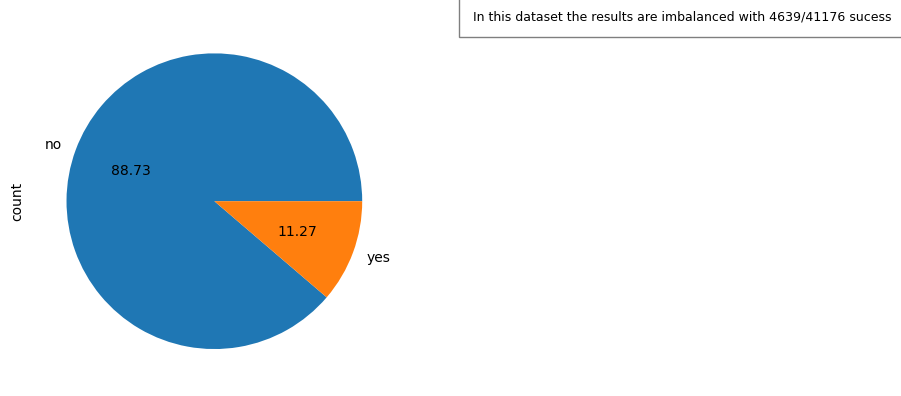

In [12]:
data['y'].value_counts().plot.pie(autopct="%.2f")
plt.annotate('In this dataset the results are imbalanced with 4639/41176 sucess',
            xy = (1.2, 1.0),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=9,
             bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})


In [13]:
bins = [-np.inf,20,40,60,80,np.inf]
bin_names = ['age_less_than_20_yrs' ,'age_between_20_and_40_yrs','age_between_40_and_60_yrs', 'age_between_60_and_80_yrs','age_above_100_yrs']
data['age_category'] = pd.cut(data.age, bins=bins, labels=bin_names, right=False, include_lowest=True)
hue_order = data['age_category'].unique()

Text(0.5, 1.0, 'Accepted Term Deposit Subscription by Job and Age Group \n The campaigns are more successful with clients who work as admin or technician and are between 20 and 40 years old ')

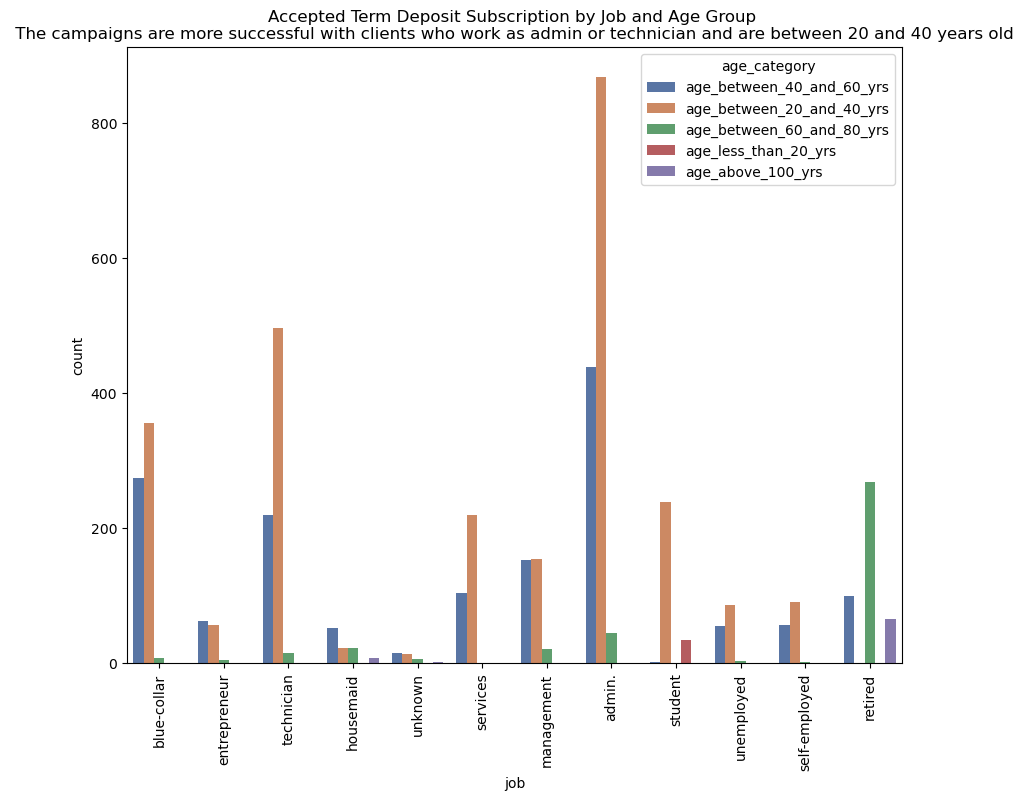

In [14]:
#let's check accepted term deposit subscription (yes = 1) v job by age category
plt.figure(figsize=(10, 8))
sns.countplot(data=data.query("y == 'yes' "), x='job', hue='age_category',hue_order=hue_order,palette = "deep")
plt.xticks(rotation = 90)
plt.title('Accepted Term Deposit Subscription by Job and Age Group \n The campaigns are more successful with clients who work as admin or technician and are between 20 and 40 years old ')

Text(0.5, 1.0, 'Accepted Term Deposit Subscription by Education and Age Group \n The campaigns are more successful with clients who have university degrees and are between 20 and 40 years old ')

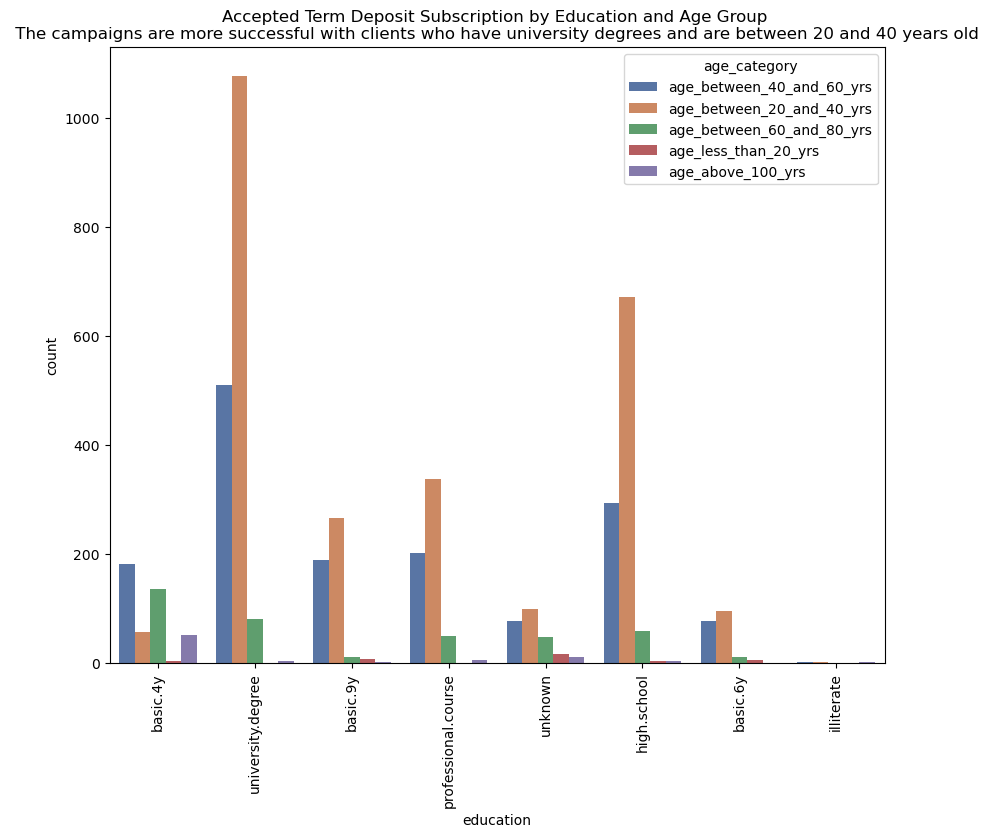

In [15]:
#let's check accepted term deposit subscription (yes = 1) v education by age category
plt.figure(figsize=(10, 8))
sns.countplot(data=data.query("y == 'yes' "), x='education', hue='age_category',hue_order=hue_order,palette = "deep")
plt.xticks(rotation = 90)
plt.title('Accepted Term Deposit Subscription by Education and Age Group \n The campaigns are more successful with clients who have university degrees and are between 20 and 40 years old ')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Answer <br> ***The business objective is to identify if a client chooses (target == yes) a long-term deposit after a marketing campaing. In order to do so, we want to identify a predictive model that classifies the target data.***

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [17]:
data['term_deposit_subscription'] = data['y'].map({'yes' : 1,'no' : 0})
data[['term_deposit_subscription']].value_counts()

term_deposit_subscription
0                            36537
1                             4639
Name: count, dtype: int64

***since the target is imbalanced and expect the models to be affected, let's undersample the majority class and compare the results as well***

In [18]:
from sklearn.utils import resample

minority_class = data[data['term_deposit_subscription'] == 1]
majority_class = data[data['term_deposit_subscription'] == 0]

# Undersample the majority class
majority_class_undersampled = resample(majority_class, 
                                       replace=False,    # sample without replacement
                                       n_samples=len(minority_class), # to match minority class
                                       random_state=42) # reproducible results

# Combine minority class with undersampled majority class
undersampled_data = pd.concat([minority_class, majority_class_undersampled])

# Check the new class distribution
undersampled_distribution = undersampled_data['y'].value_counts()
undersampled_distribution

y
yes    4639
no     4639
Name: count, dtype: int64

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [19]:
# Define numerical and categorical features
numerical_features = ['age',  'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','day_of_week', 'poutcome']

# Create a preprocessing pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])


In [20]:
selected_features = numerical_features + categorical_features
X = data[selected_features].copy()
y = data['term_deposit_subscription'].copy()

In [21]:
# ... also setup using the undersampled data
X_ud = undersampled_data[selected_features].copy()
y_ud = undersampled_data['term_deposit_subscription'].copy()

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [22]:
# Split the imbalanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the undersampled data into training and testing sets
X_ud_train, X_ud_test, y_ud_train, y_ud_test = train_test_split(X_ud, y_ud, test_size=0.2, random_state=42)

In [23]:
#let's take a look
split_type = ['X_train', 'X_test','y_train','y_test','X_ud_train', 'X_ud_test','y_ud_train','y_ud_test']
shape_info = [X_train.shape, X_test.shape, y_train.shape, y_test.shape,
              X_ud_train.shape, X_ud_test.shape, y_ud_train.shape, y_ud_test.shape]
split_results_df = pd.DataFrame({'data_split': split_type, 'shape': shape_info})
split_results_df

,data_split,shape
0,X_train,"(32940, 15)"
1,X_test,"(8236, 15)"
2,y_train,"(32940,)"
3,y_test,"(8236,)"
4,X_ud_train,"(7422, 15)"
5,X_ud_test,"(1856, 15)"
6,y_ud_train,"(7422,)"
7,y_ud_test,"(1856,)"


In [24]:
results = { }

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

***Note: I chose RandomForestClassifier as a baseline model becasue it performs well on categorical and numerical data, and typically it performs well.***

In [25]:
baseline_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestClassifier())])

In [26]:
start = time()
baseline_pipe.fit(X_train, y_train)
stop = time()
base_y_train = baseline_pipe.predict(X_train)
base_y_pred = baseline_pipe.predict(X_test)
print("RandomForestClassifier: ", stop - start,"(s) \n\n")
results['RandomForestClassifier'] = {
    'y_pred' : base_y_pred,
    'train_time' : stop - start,
    'accuracy_on_train_data': accuracy_score(y_train, base_y_train),
    'accuracy_on_test_data': accuracy_score(y_test, base_y_pred),
    'f1_score': f1_score(y_test, base_y_pred, average='weighted')
}

RandomForestClassifier:  50.98111343383789 (s) 




### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

***Note: LogisticRegression is efficient and performs well on binary classification, it also allows us to identify the coefficient of each feature to understand the strength and direction on the prediction.***

In [27]:
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', LogisticRegression())])

In [28]:
start = time()
logreg_pipeline.fit(X_train, y_train)
stop = time()
logreg_y_train = logreg_pipeline.predict(X_train)
logreg_y_pred = logreg_pipeline.predict(X_test)
print("LogisticRegression: ", stop - start,"(s) \n\n")
results['LogisticRegression'] = {
    'y_pred' : logreg_y_pred,
    'train_time' : stop - start,
    'accuracy_on_train_data': accuracy_score(y_train, logreg_y_train),
    'accuracy_on_test_data': accuracy_score(y_test, logreg_y_pred),
    'f1_score': f1_score(y_test, logreg_y_pred, average='weighted')
}

LogisticRegression:  0.5995006561279297 (s) 




### Problem 9: Score the Model

What is the accuracy of your model?

***Observation: RandomForestClassifier has a higher training score than LogisticRegression but seems to be overfitting. Though, their testing scores are very similar.***

In [29]:
print('baseline model (RandomForestClassifier) score on training data: ',results['RandomForestClassifier']['accuracy_on_train_data'])
print('baseline model (RandomForestClassifier) score on test data: ',results['RandomForestClassifier']['accuracy_on_test_data'])
print('simple model (LogisticRegression) score on training data: ',results['LogisticRegression']['accuracy_on_train_data']) 
print('simple model (LogisticRegression) score on test data: ',results['LogisticRegression']['accuracy_on_test_data'])

baseline model (RandomForestClassifier) score on training data:  1.0
baseline model (RandomForestClassifier) score on test data:  0.9020155415250122
simple model (LogisticRegression) score on training data:  0.9085913782635094
simple model (LogisticRegression) score on test data:  0.9034725594949005


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

***Observation: KNN has the lowest train time, while SVM has the highest. Decision Tree and RandomForestClassifier seem to overfit during training; and LogisticRegression still performs best during testing.***

In [30]:
def fit_predict(model_name, pipeline, X_trn, X_tst, y_trn, y_tst):
    start = time()
    pipeline.fit(X_trn, y_trn)
    stop = time()
    pipeline_y_train = pipeline.predict(X_trn)
    pipeline_y_pred = pipeline.predict(X_tst)
    print(model_name, ": ", stop - start,"(s) \n\n")
    results[model_name] = {
        'y_pred' : pipeline_y_pred,
        'train_time' : stop - start,
        'accuracy_on_train_data': accuracy_score(y_trn, pipeline_y_train),
        'accuracy_on_test_data': accuracy_score(y_tst, pipeline_y_pred),
        'f1_score': f1_score(y_tst, pipeline_y_pred, average='weighted')
    }

In [31]:
fit_predict('KNN', Pipeline(steps=[('preprocessor', preprocessor),('model', KNeighborsClassifier())]),
            X_train, X_test, y_train, y_test)

KNN :  0.3610682487487793 (s) 




In [32]:
fit_predict('Decision Tree', Pipeline(steps=[('preprocessor', preprocessor),('model', DecisionTreeClassifier())]), 
            X_train, X_test, y_train, y_test)

Decision Tree :  3.206015110015869 (s) 




In [33]:
fit_predict('SVM', Pipeline(steps=[('preprocessor', preprocessor),('model', SVC())]), 
            X_train, X_test, y_train, y_test)

SVM :  61.30913472175598 (s) 




In [34]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Time': [results[model]['train_time'] for model in results],
    'Train Accuracy': [results[model]['accuracy_on_train_data'] for model in results],
    'Test Accuracy': [results[model]['accuracy_on_test_data'] for model in results]
})
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,RandomForestClassifier,50.981113,1.000000,0.902016
1,LogisticRegression,0.599501,0.908591,0.903473
2,KNN,0.361068,0.923710,0.898009
3,Decision Tree,3.206015,1.000000,0.870690
4,SVM,61.309135,0.917638,0.901530


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Feature exploration

***Observation: the duration has a high impact on the target, then the time (day and month) of the campaing. Education and job of the client also have an impact on the target. An intersting observation is that age doesn't seem to be impacting much.***

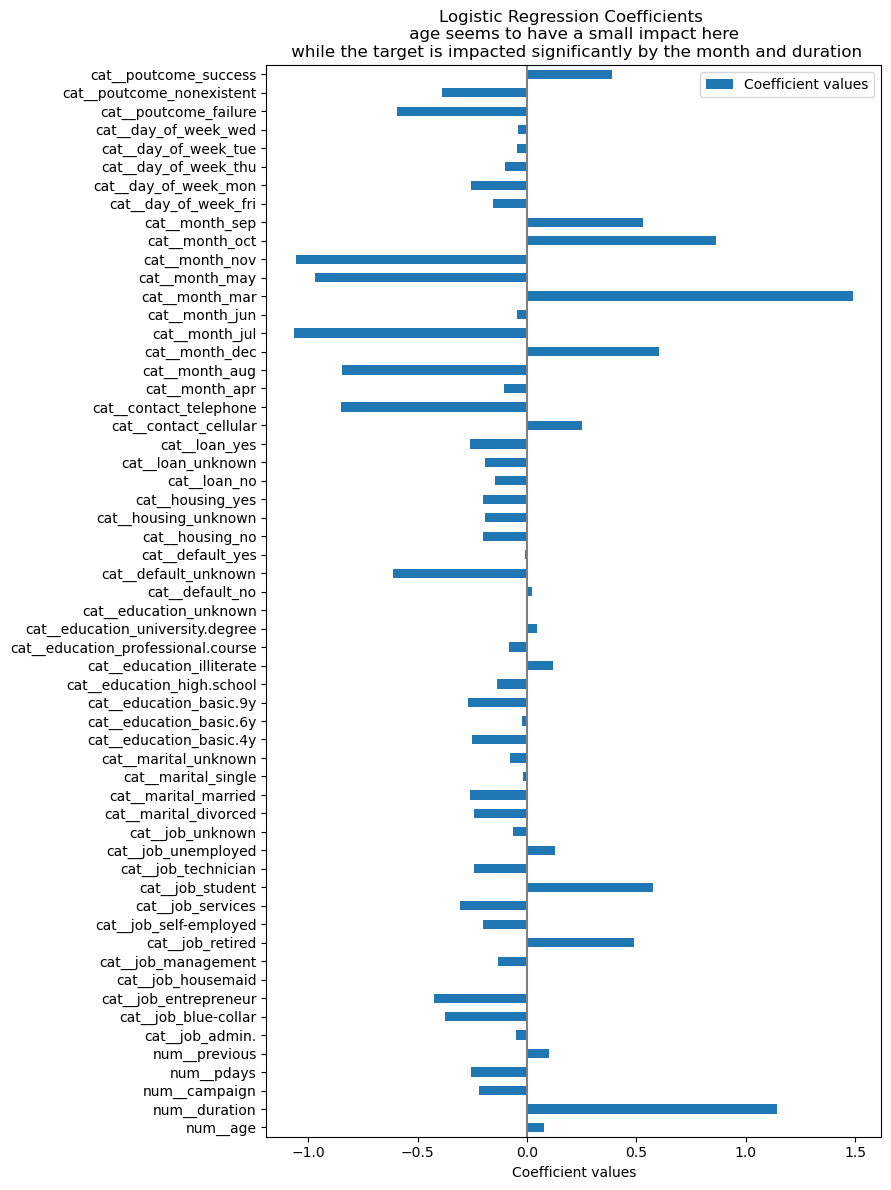

In [35]:
feature_names = logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefs = pd.DataFrame(
    logreg_pipeline.named_steps['model'].coef_.flatten(), 
    columns=["Coefficient values"], 
    index=feature_names
)

coefs.plot.barh(figsize=(9, 12))
titlestr = "Logistic Regression Coefficients \n age seems to have a small impact here \n while the target is impacted significantly by the month and duration"
plt.title(titlestr)
plt.xlabel("Coefficient values")

plt.axvline(x=0, color=".5")
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

***Let's investigate age a little bit more***

***Observation: as suspected, the age is a factor which age category helps illustrate.***

In [36]:
agebycateogry_features = ['age_category']
agebycateogry_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
agebycateogry_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('agecat', agebycateogry_pipeline, agebycateogry_features),
        ('cat', categorical_pipeline, categorical_features)
    ])


In [37]:
X_agecat = X.copy()
X_agecat['age_category'] = data['age_category'].copy()
agecat_logreg_pipeline = Pipeline(steps=[('preprocessor', agebycateogry_preprocessor),
                                  ('model', LogisticRegression())])
X1_train, X1_test, y1_train, y1_test = train_test_split(X_agecat, y, test_size=0.2, random_state=42)
start = time()
agecat_logreg_pipeline.fit(X1_train, y1_train)
stop = time()
agecat_logreg_y_train = agecat_logreg_pipeline.predict(X1_train)
agecat_logreg_y_pred = agecat_logreg_pipeline.predict(X1_test)
print("LogisticRegression (with age category data): ", stop - start,"(s) \n\n")
results['LogisticRegression (with age category data)'] = {
    'y_pred' : agecat_logreg_y_pred,
    'train_time' : stop - start,
    'accuracy_on_train_data': accuracy_score(y1_train, agecat_logreg_y_train),
    'accuracy_on_test_data': accuracy_score(y1_test, agecat_logreg_y_pred),
    'f1_score': f1_score(y1_test, agecat_logreg_y_pred, average='weighted')
}

LogisticRegression (with age category data):  0.6480832099914551 (s) 




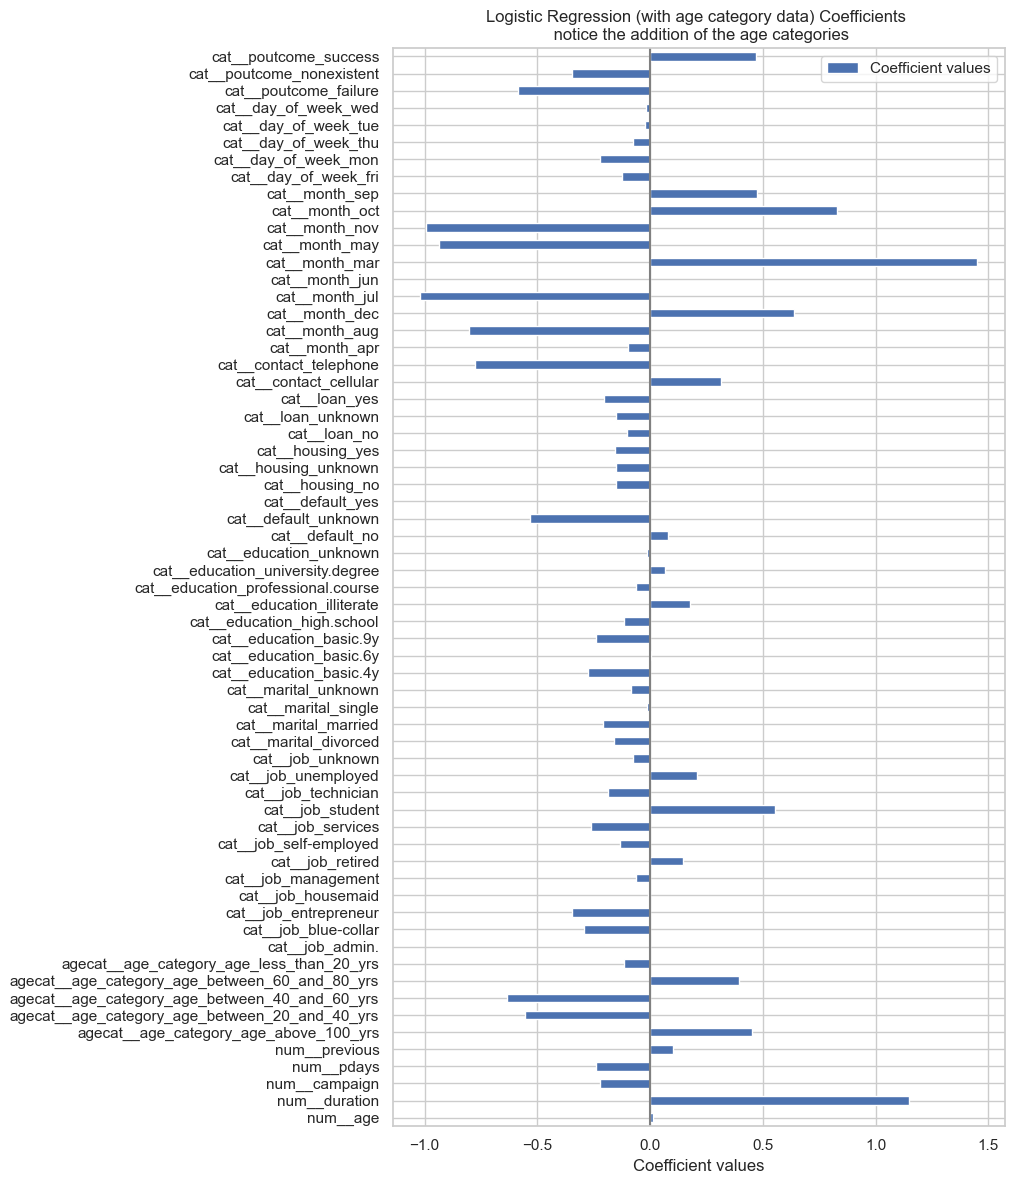

In [67]:
feature_names = agecat_logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefs = pd.DataFrame(
    agecat_logreg_pipeline.named_steps['model'].coef_.flatten(), 
    columns=["Coefficient values"], 
    index=feature_names
)

coefs.plot.barh(figsize=(9, 12))
titlestr = "Logistic Regression (with age category data) Coefficients \n notice the addition of the age categories"
plt.title(titlestr)
plt.xlabel("Coefficient values")

plt.axvline(x=0, color=".5")
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

#### Hyperparameter tuning and grid search

***Observation: GridSearch with SVM is very costly in training time, while achiving similar train and test scores to the other models. GridSearch with LogisticRegression has the lowest train time and still keeping a relatively competitive train and test scores.***

In [39]:
gridsearch_results = {}
def gridsearch_fit_predict(model_name, pipeline, params, X_trn, X_tst, y_trn, y_tst):
    grid_search = GridSearchCV(pipeline, params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    start = time()
    grid_search.fit(X_trn, y_trn)
    stop = time()
    print(model_name, ": ", stop - start,"(s) \n")
    # Extract best results
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("best_params: ",best_params,"\nbest_score: ",best_score,"\n\n")
    y_prd = best_model.predict(X_tst)
    gridsearch_results[model_name] = {
        'y_pred' : y_prd,
        'best_model': best_model,
        'best_params': best_params,
        'best_score': best_score,
        'train_time': stop - start,
        'accuracy_on_test_data': accuracy_score(y_tst, y_prd),
        'f1_score': f1_score(y_tst, y_prd, average='weighted')
    }

In [40]:
# RandomForestClassifier
rfc_params = [{'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]}]
gridsearch_fit_predict('GridSearch with RandomForestClassifier', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestClassifier())]),
                       rfc_params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with RandomForestClassifier :  312.8831295967102 (s) 

best_params:  {'model__max_depth': 20, 'model__n_estimators': 100} 
best_score:  0.9085306618093503 




In [41]:
#LogisticRegression
lr_params = [{'model__penalty': ['l2'],'model__C': [0.1, 1, 10]}]
gridsearch_fit_predict('GridSearch with LogisticRegression', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', LogisticRegression())]), 
                       lr_params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
GridSearch with LogisticRegression :  2.954176664352417 (s) 

best_params:  {'model__C': 10, 'model__penalty': 'l2'} 
best_score:  0.9076199149969643 




In [42]:
# KNN
knn_params = [{'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']}]
gridsearch_fit_predict('GridSearch with KNN', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', KNeighborsClassifier())]),
                       knn_params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with KNN :  132.09204149246216 (s) 

best_params:  {'model__n_neighbors': 7, 'model__weights': 'uniform'} 
best_score:  0.9010625379477839 




In [43]:
# Decision Tree
dt_params = [{'model__max_depth': [None, 10, 20],'model__min_samples_split': [2, 5, 10]}]
gridsearch_fit_predict('GridSearch with DecisionTree', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', DecisionTreeClassifier())]),
                       dt_params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
GridSearch with DecisionTree :  18.403796672821045 (s) 

best_params:  {'model__max_depth': 10, 'model__min_samples_split': 10} 
best_score:  0.9047055251973285 




In [44]:
# SVM
svm_params = [{'model__C': [0.1, 1, 10],'model__kernel': ['linear', 'rbf']}]
gridsearch_fit_predict('GridSearch with SVM', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', SVC())]), 
                       svm_params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with SVM :  3582.614905357361 (s) 

best_params:  {'model__C': 1, 'model__kernel': 'rbf'} 
best_score:  0.9072252580449301 




In [45]:
gridsearch_results_df = pd.DataFrame({
    'Model': list(gridsearch_results.keys()),
    'Train Time': [gridsearch_results[model]['train_time'] for model in gridsearch_results],
    'Train Accuracy': [gridsearch_results[model]['best_score'] for model in gridsearch_results],
    'Test Accuracy': [gridsearch_results[model]['accuracy_on_test_data'] for model in gridsearch_results]
})
gridsearch_results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,GridSearch with RandomForestClassifier,312.883130,0.908531,0.903473
1,GridSearch with LogisticRegression,2.954177,0.907620,0.903594
2,GridSearch with KNN,132.092041,0.901063,0.899223
3,GridSearch with DecisionTree,18.403797,0.904706,0.901287
4,GridSearch with SVM,3582.614905,0.907225,0.901530


## ... and now let's explore the models with undersampled data

***Create pipelines for each classifier, fit and test with the undersampled data***

In [46]:
fit_predict('Random Forest undersampled data', Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestClassifier())]),
            X_ud_train, X_ud_test, y_ud_train, y_ud_test)

Random Forest undersampled data :  4.65525221824646 (s) 




In [47]:
fit_predict('Logistic Regression undersampled data', Pipeline(steps=[('preprocessor', preprocessor),('model', LogisticRegression())]),
            X_ud_train, X_ud_test, y_ud_train, y_ud_test)

Logistic Regression undersampled data :  0.08300495147705078 (s) 




In [48]:
fit_predict('KNN undersampled data', Pipeline(steps=[('preprocessor', preprocessor),('model', KNeighborsClassifier())]),
            X_ud_train, X_ud_test, y_ud_train, y_ud_test)

KNN undersampled data :  0.04303550720214844 (s) 




In [49]:
fit_predict('Decision Tree undersampled data', Pipeline(steps=[('preprocessor', preprocessor),('model', DecisionTreeClassifier())]), 
            X_ud_train, X_ud_test, y_ud_train, y_ud_test)

Decision Tree undersampled data :  0.3619997501373291 (s) 




In [50]:
fit_predict('SVM undersampled data', Pipeline(steps=[('preprocessor', preprocessor),('model', SVC())]), 
            X_ud_train, X_ud_test, y_ud_train, y_ud_test)

SVM undersampled data :  2.7187650203704834 (s) 




In [51]:
results_with_ud_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Time': [results[model]['train_time'] for model in results],
    'Train Accuracy': [results[model]['accuracy_on_train_data'] for model in results],
    'Test Accuracy': [results[model]['accuracy_on_test_data'] for model in results]
})
results_with_ud_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,RandomForestClassifier,50.981113,1.000000,0.902016
1,LogisticRegression,0.599501,0.908591,0.903473
2,KNN,0.361068,0.923710,0.898009
3,Decision Tree,3.206015,1.000000,0.870690
4,SVM,61.309135,0.917638,0.901530
5,LogisticRegression (with age category data),0.648083,0.908591,0.903351
6,Random Forest undersampled data,4.655252,1.000000,0.852371
7,Logistic Regression undersampled data,0.083005,0.848289,0.832974
8,KNN undersampled data,0.043036,0.866343,0.795797
9,Decision Tree undersampled data,0.362000,1.000000,0.800108


In [52]:
gridsearch_fit_predict('GridSearch with RandomForestClassifier (undersampled data)', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestClassifier())]),
                       rfc_params, X_ud_train, X_ud_test, y_ud_train, y_ud_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with RandomForestClassifier (undersampled data) :  37.469266414642334 (s) 

best_params:  {'model__max_depth': 20, 'model__n_estimators': 200} 
best_score:  0.8637846569922042 




In [53]:
gridsearch_fit_predict('GridSearch with LogisticRegression (undersampled data)', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', LogisticRegression())]), 
                       lr_params, X_ud_train, X_ud_test, y_ud_train, y_ud_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
GridSearch with LogisticRegression (undersampled data) :  0.5816640853881836 (s) 

best_params:  {'model__C': 10, 'model__penalty': 'l2'} 
best_score:  0.846267164003013 




In [54]:
gridsearch_fit_predict('GridSearch with KNN (undersampled data)', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', KNeighborsClassifier())]),
                       knn_params, X_ud_train, X_ud_test, y_ud_train, y_ud_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with KNN (undersampled data) :  4.375751733779907 (s) 

best_params:  {'model__n_neighbors': 7, 'model__weights': 'uniform'} 
best_score:  0.8057131966565929 




In [55]:
gridsearch_fit_predict('GridSearch with DecisionTree (undersampled data)', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', DecisionTreeClassifier())]),
                       dt_params, X_ud_train, X_ud_test, y_ud_train, y_ud_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
GridSearch with DecisionTree (undersampled data) :  2.2877485752105713 (s) 

best_params:  {'model__max_depth': 10, 'model__min_samples_split': 5} 
best_score:  0.8249799885648942 




In [56]:
gridsearch_fit_predict('GridSearch with SVM (undersampled data)', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', SVC())]), 
                       svm_params, X_ud_train, X_ud_test, y_ud_train, y_ud_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with SVM (undersampled data) :  27.21137261390686 (s) 

best_params:  {'model__C': 1, 'model__kernel': 'rbf'} 
best_score:  0.8617616415729623 




In [57]:
gridsearch_results_with_ud_df = pd.DataFrame({
    'Model': list(gridsearch_results.keys()),
    'Train Time': [gridsearch_results[model]['train_time'] for model in gridsearch_results],
    'Train Accuracy': [gridsearch_results[model]['best_score'] for model in gridsearch_results],
    'Test Accuracy': [gridsearch_results[model]['accuracy_on_test_data'] for model in gridsearch_results]
})
gridsearch_results_with_ud_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,GridSearch with RandomForestClassifier,312.883130,0.908531,0.903473
1,GridSearch with LogisticRegression,2.954177,0.907620,0.903594
2,GridSearch with KNN,132.092041,0.901063,0.899223
3,GridSearch with DecisionTree,18.403797,0.904706,0.901287
4,GridSearch with SVM,3582.614905,0.907225,0.901530
5,GridSearch with RandomForestClassifier (unders...,37.469266,0.863785,0.851832
6,GridSearch with LogisticRegression (undersampl...,0.581664,0.846267,0.831358
7,GridSearch with KNN (undersampled data),4.375752,0.805713,0.789871
8,GridSearch with DecisionTree (undersampled data),2.287749,0.824980,0.810345
9,GridSearch with SVM (undersampled data),27.211373,0.861762,0.851293


#### performance metrics

***Observation: While analyzing the ROC curves, hyperparameter tuning slightly improves the AUC compared to the default model, and the models have a similar performance though it seems that the Decision Tree model is slightly better.***

In [58]:
from sklearn import metrics

def pbuild_axes(ax, pred,lbldesc):
    fpr, tpr, _ = metrics.roc_curve(y_test, pred)
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{lbldesc} (AUC = {roc_auc:.2f})')

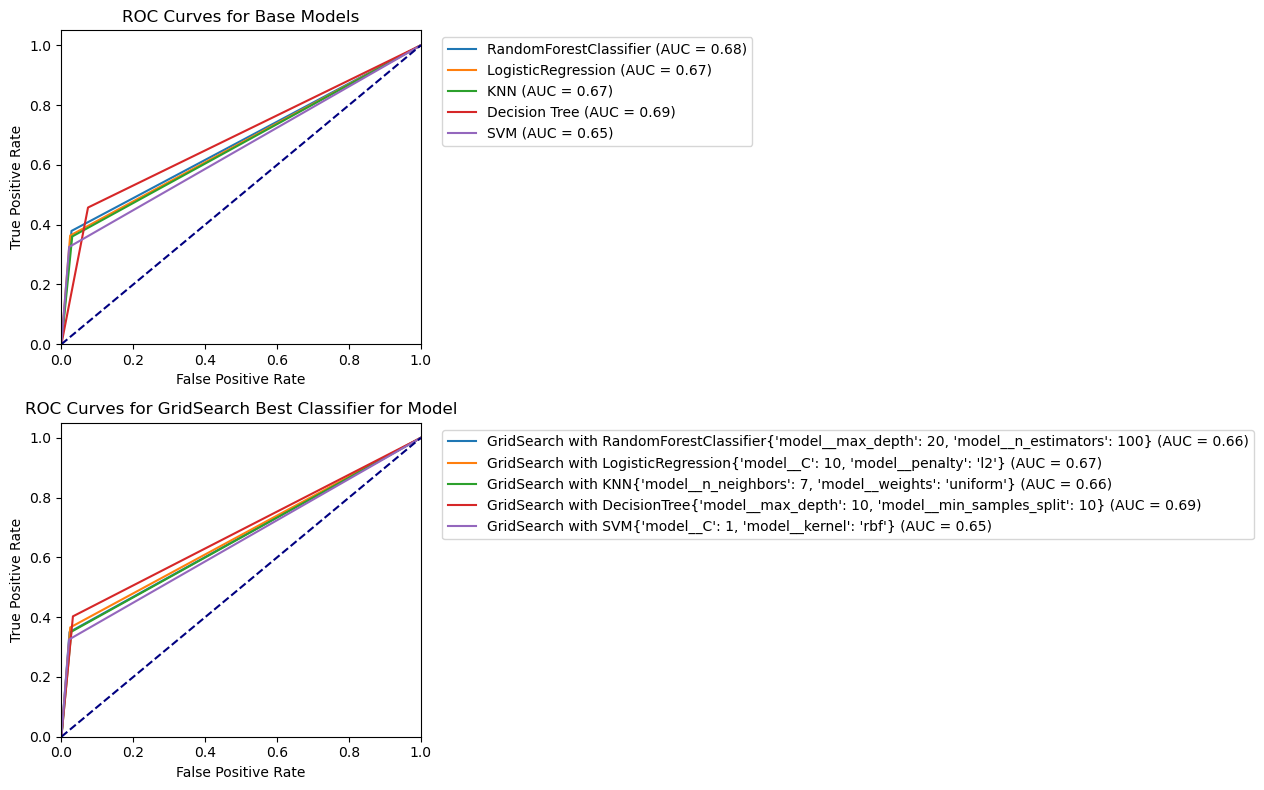

In [63]:
# Initialize subplots
models1 = ['RandomForestClassifier', 'LogisticRegression', 'KNN', 'Decision Tree', 'SVM']
models2 = ['GridSearch with RandomForestClassifier','GridSearch with LogisticRegression',
            'GridSearch with KNN','GridSearch with DecisionTree','GridSearch with SVM']

fig, axes = plt.subplots(2, 1, figsize=(13, 8))

for key in results.keys():
    if key in models1:
        pbuild_axes(axes[0], results[key]['y_pred'],key)
axes[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves for Base Models')
axes[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

for key in gridsearch_results.keys():
    if key in models2:
        pbuild_axes(axes[1], gridsearch_results[key]['y_pred'],key+str(gridsearch_results[key]['best_params']))
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves for GridSearch Best Classifier for Model')
axes[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# Adjust layout and show plot
plt.tight_layout()
plt.show()

##### Result Summary

***Observation: viewing the results on a point plot clarifies the effect of hyperparameter tuning on the model scores (and the f1 score in particular). The Decision Tree model lags being in test and f1 scores and GridSearch with SVM has the highest training time.***

In [64]:
from IPython.display import HTML
results1_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Time': [results[model]['train_time'] for model in results],
    'Train Accuracy': [results[model]['accuracy_on_train_data'] for model in results],
    'Test Accuracy': [results[model]['accuracy_on_test_data'] for model in results],
    'f1 Score' : [results[model]['f1_score'] for model in results],
    'Best Params' : 'Default'
})

results2_df = pd.DataFrame({
    'Model': list(gridsearch_results.keys()),
    'Train Time': [gridsearch_results[model]['train_time'] for model in gridsearch_results],
    'Train Accuracy': [gridsearch_results[model]['best_score'] for model in gridsearch_results],
    'Test Accuracy': [gridsearch_results[model]['accuracy_on_test_data'] for model in gridsearch_results],
    'f1 Score' : [gridsearch_results[model]['f1_score'] for model in gridsearch_results],
    'Best Params' : [gridsearch_results[model]['best_params'] for model in gridsearch_results]
})
summary_results_df = pd.concat([results1_df, results2_df], ignore_index=True)

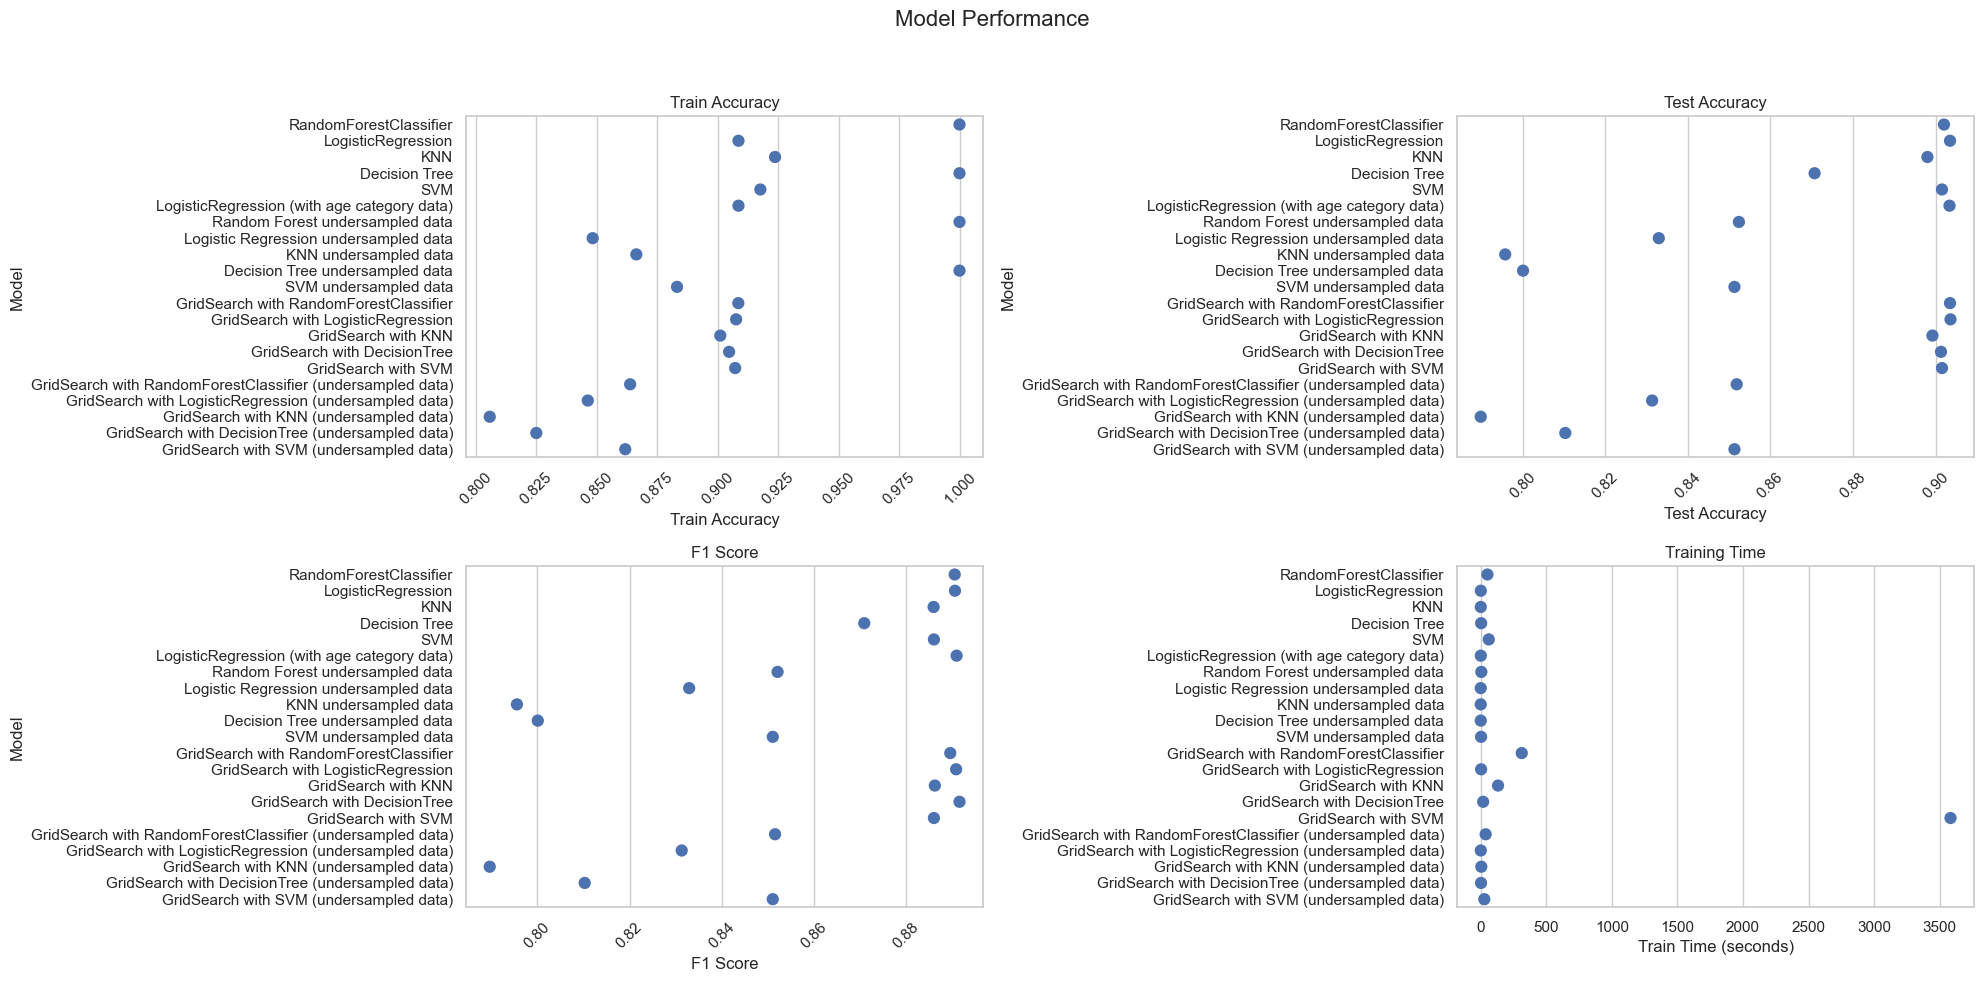

In [65]:
sns.set(style="whitegrid")

# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Set the overall title
fig.suptitle('Model Performance', fontsize=16)

# Plot Train Accuracy Score
sns.pointplot(ax=axes[0,0], x="Train Accuracy", y="Model", data=summary_results_df, join=False)
axes[0,0].set_title('Train Accuracy')
axes[0,0].set_xlabel('Train Accuracy')
axes[0,0].set_ylabel('Model')
axes[0,0].tick_params(axis='x', rotation=45)  

# Plot Test Accuracy Score
sns.pointplot(ax=axes[0,1], x="Test Accuracy", y="Model", data=summary_results_df, join=False)
axes[0,1].set_title('Test Accuracy')
axes[0,1].set_xlabel('Test Accuracy')
axes[0,1].set_ylabel('Model')
axes[0,1].tick_params(axis='x', rotation=45)  

# Plot F1 Score
sns.pointplot(ax=axes[1,0], x="f1 Score", y="Model", data=summary_results_df, join=False)
axes[1,0].set_title('F1 Score')
axes[1,0].set_xlabel('F1 Score')
axes[1,0].set_ylabel('Model')
axes[1,0].tick_params(axis='x', rotation=45)  

# Plot Training Time
sns.pointplot(ax=axes[1,1], x="Train Time", y="Model", data=summary_results_df, join=False)
axes[1,1].set_title('Training Time')
axes[1,1].set_xlabel('Train Time (seconds)')
axes[1,1].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


In [66]:
HTML(summary_results_df.to_html(classes='table table-stripped'))

,Model,Train Time,Train Accuracy,Test Accuracy,f1 Score,Best Params
0,RandomForestClassifier,50.981113,1.000000,0.902016,0.890656,Default
1,LogisticRegression,0.599501,0.908591,0.903473,0.890714,Default
2,KNN,0.361068,0.923710,0.898009,0.886070,Default
3,Decision Tree,3.206015,1.000000,0.870690,0.871005,Default
4,SVM,61.309135,0.917638,0.901530,0.886139,Default
5,LogisticRegression (with age category data),0.648083,0.908591,0.903351,0.891073,Default
6,Random Forest undersampled data,4.655252,1.000000,0.852371,0.852167,Default
7,Logistic Regression undersampled data,0.083005,0.848289,0.832974,0.832964,Default
8,KNN undersampled data,0.043036,0.866343,0.795797,0.795539,Default
9,Decision Tree undersampled data,0.362000,1.000000,0.800108,0.800069,Default


#### Evaluation

We evaluated the performance of various models the best performing model is LogisticRegression with GridSearch on the original dataset
with good balance of performance metrics and training time.<br>
RandomForestClassifier and Decision Tree models show signs of overfitting in both original and undersampled data. We expected that 
undersampling the majority target class would improve metrics, but instead it lowered the test accuracy and F1 score. 
<br>This indicates that undersampling is not effective in this dataset. Using GridSearch increased metrics but the gains may not justify the increase on
train time. This is very obvious with SVM.